In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
#Baixa, Organiza e carrega os dados de treino e validação
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_extracted', 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Path to zip file: /home/nathannss/.keras/datasets/cats_and_dogs_extracted
Expected extracted path: /home/nathannss/.keras/datasets/cats_and_dogs_filtered
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2025-07-29 08:32:25.977136: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


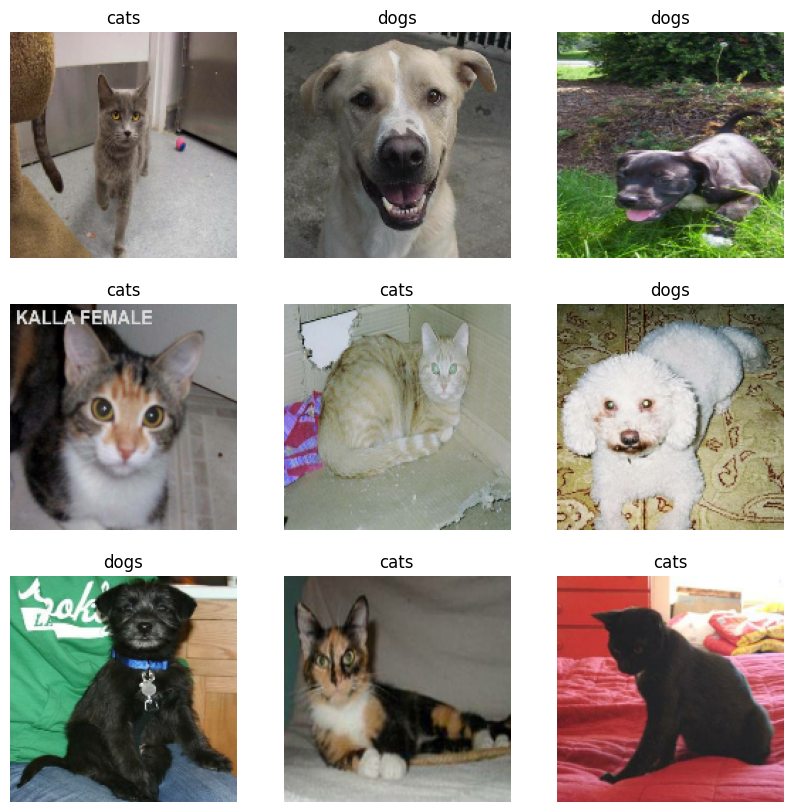

In [ ]:
#Exibição das imagens com seus rótulos
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
# Criando os dados de teste
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 3


In [17]:
#Otimização de desempenho no carregamento de imagens
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

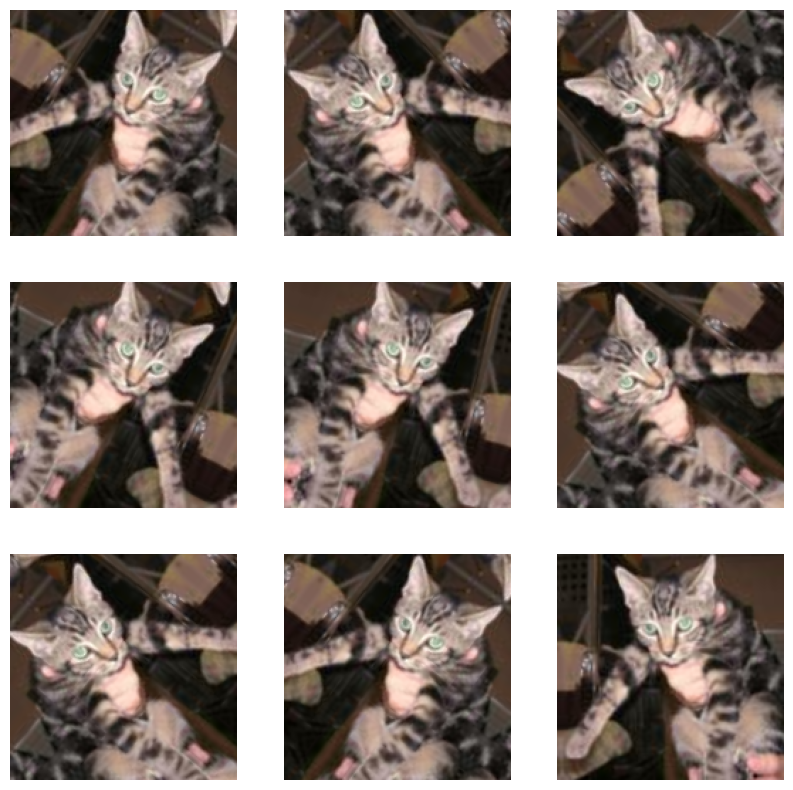

In [18]:
#Introduzindo diversidade amostral aplicando transformações aleatórias
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

#Apenas a Exibição
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#Usada futuramente para redimensionar os valor para [1, -1] para o modelo MobileNetV2 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Carregamento do modelo MobileNetV2 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
# Passa as imagens no MobileNetV2 para extrair características e retorna um tensor reduzido
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

I0000 00:00:1753793076.072537   13030 cuda_dnn.cc:529] Loaded cuDNN version 90300


(32, 5, 5, 1280)


In [22]:
#Congelamento da base convolucional

base_model.trainable = False

# Ver características do modelo base
# base_model.summary()

In [ ]:
# Reduzir a dimensionalidade do modelo base de 3D(32, 5, 5, 1280) para 1D(32, 1280)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#Consolidação do modelo com as funcionalidades anteriormente construídas 
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Ver características do modelo
# model.summary()

In [37]:
#Compilação do Modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
#Avaliação do desempenho do modelo antes do treinamento
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6011 - loss: 0.6599
initial loss: 0.67
initial accuracy: 0.61


In [ ]:
#Treinamento do Modelo
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6472 - loss: 0.6348 - val_accuracy: 0.7783 - val_loss: 0.4533
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7874 - loss: 0.4640 - val_accuracy: 0.8703 - val_loss: 0.3558
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8332 - loss: 0.3920 - val_accuracy: 0.9080 - val_loss: 0.2817
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8650 - loss: 0.3432 - val_accuracy: 0.9363 - val_loss: 0.2398
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8956 - loss: 0.2850 - val_accuracy: 0.9363 - val_loss: 0.2061
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8903 - loss: 0.2795 - val_accuracy: 0.9458 - val_loss: 0.1898
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8983 - loss: 0.2617 - val_accuracy: 0.9623 - val_loss: 0.1681
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9006 - loss: 0.2581 - val_accuracy: 0.9741 - 

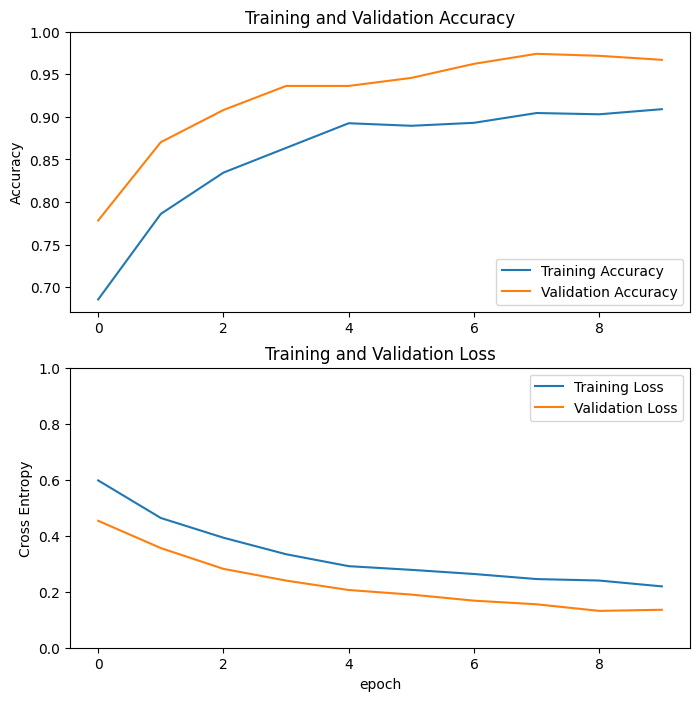

In [40]:
#Geração dos gráficos de aprendizado do modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
#Descongele as camadas superiores do modelo

base_model.trainable = True

# Mostrar quantas camadas o modelo tem
print("Number of layers in the base model: ", len(base_model.layers))

# A parti desta camada será feito o fine tune(Refinamento)  
fine_tune_at = 100

# Congelando as camadas inferiores com a variável definida a cima
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#Recompilando o modelo com os pesos novo e as partes descongeladas

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

#Ver as características do modelo
# model.summary()
# len(model.trainable_variables)

In [43]:
#Treinar novamente o modelo, mas agora o refinamento
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.7749 - loss: 0.4612 - val_accuracy: 0.9623 - val_loss: 0.1003
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8571 - loss: 0.3239 - val_accuracy: 0.9717 - val_loss: 0.0823
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9217 - loss: 0.2120 - val_accuracy: 0.9764 - val_loss: 0.0674
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9185 - loss: 0.1974 - val_accuracy: 0.9811 - val_loss: 0.0516
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9350 - loss: 0.1721 - val_accuracy: 0.9788 - val_loss: 0.0579
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9457 - loss: 0.1514 - val_accuracy: 0.9764 - val_loss: 0.0673
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9319 - loss: 0.1573 - val_accuracy: 0.9764 - val_loss: 0.0553
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9403 - loss: 0.1483 - val_acc

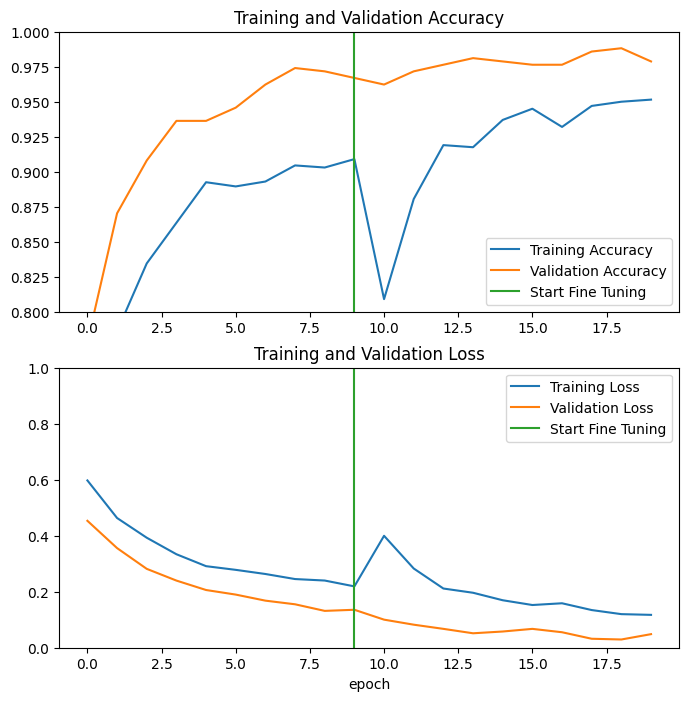

In [44]:
#Geração dos gráficos do reaprendizado do modelo

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Usando os dados reservados de teste no inicio para testa-lo
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9909 - loss: 0.0231
Test accuracy : 0.9895833134651184


Predictions:
 [0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0]
Labels:
 [0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0]


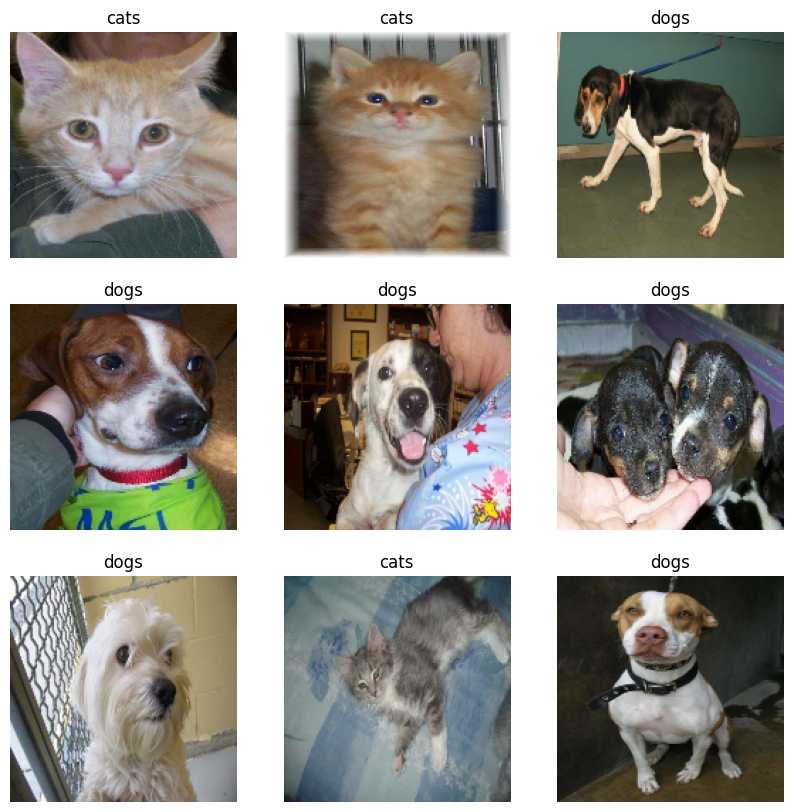

In [47]:
# Usando o modelo treinado
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")